# Library Installation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

# Load Datasets

In [4]:
def load_application_train():
    data = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
    return data

In [5]:
def load():
    data = pd.read_csv("/kaggle/input/titanic/train.csv")
    return data

In [6]:
df = load()
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C


# How to catch outliers?

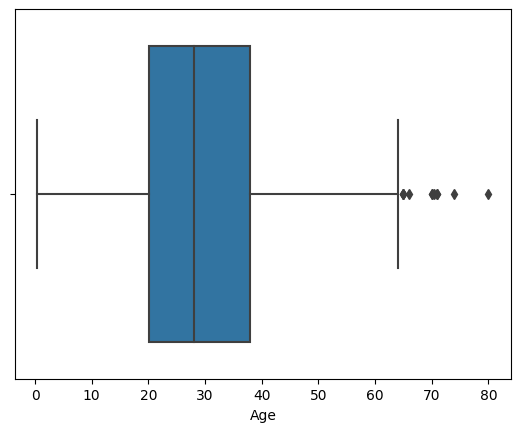

In [7]:
# Outliers with Chart Technique
# Outliers can be observed on the chart.

sns.boxplot(x=df["Age"])
plt.show()

In [8]:
# Seaborn's boxplot function provides a statistical summary when dividing the data into four parts,
# and this summary includes the following components:
# - Minimum (Q0): The smallest value of the data.
# - First Quarter (Q1): The 25th percentile of the data. This is the value that falls under one-quarter of the data.
# - Median (Q2): The median value of the data, i.e. the value below half and above half of the data.
# - Third Quarter (Q3): 75 per cent of the data. This is the value below three quarters of the data.
# - Maximum (Q4): The largest value of the data.

# These components are represented in a box plot in the figure below:

# - Box: Located between Q1 and Q3 and the horizontal line inside the box represents the median (Q2).
# - Whiskers: Usually located between Q1 - 1.5* IQR and Q3 + 1.5* IQR (IQR is Q3 - Q1, i.e. interquartile range).
#             Data outside the whiskers are usually considered as "outliers" and are shown as separate points on the graph.


q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

In [9]:
# Outliers found

df[(df["Age"] < low) | (df["Age"] > up)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.000,0,0,C.A. 24579,10.500,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.000,0,1,113509,61.979,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.000,0,0,PC 17754,34.654,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.500,0,0,370369,7.750,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.000,0,0,336439,7.750,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.000,0,0,13509,26.550,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.000,0,0,PC 17609,49.504,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.000,0,0,27042,30.000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.000,0,0,C.A. 24580,10.500,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.000,1,1,WE/P 5735,71.000,B22,S


In [10]:
# We find the indexes of the rows with outliers found. Because we will do this with functions in the form of pipeline.

df[(df["Age"] < low) | (df["Age"] > up)].index

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [11]:
# The code to get a true or false answer for outliers

df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None)

True

# Outlier Thresholds

In [12]:
# This function calculates upper and lower bound thresholds for outliers in a given column of a data frame.
# The function uses the Interquartile Range (IQR) method to determine these thresholds.
# Parameters:
# dataframe: The data frame containing the data
# col_name: Name of the column for which outlier thresholds will be calculated
# q1: Lower quantile (default is 0.25)
# q3: Upper quantile (default is 0.75)
# Returns:
# low_limit: Lower limit for outliers
# up_limit: Upper limit for outliers

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Example use:
# low, high = outlier_thresholds(df, 'column_name')
# print(f "Low limit: {low}, Up Limit: {high}")

In [13]:
outlier_thresholds(df, "Age")

(-6.6875, 64.8125)

In [14]:
outlier_thresholds(df, "Fare")

(-26.724, 65.6344)

In [15]:
low, up = outlier_thresholds(df, "Fare")

In [16]:
# Outliers found

df[(df["Fare"] < low) | (df["Fare"] > up)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000,3,2,19950,263.000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.521,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.000,1,0,PC 17604,82.171,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.000,1,0,PC 17572,76.729,D33,C


In [17]:
# The indexes of the rows with outliers

df[(df["Fare"] < low) | (df["Fare"] > up)].index

Index([  1,  27,  31,  34,  52,  61,  62,  72,  88, 102,
       ...
       792, 802, 820, 829, 835, 846, 849, 856, 863, 879], dtype='int64', length=116)

# Check Outlier

In [18]:
# Outlier Check Function
# This function checks for outliers for a given column in a given data frame.
# The function sets upper and lower limits using the 'outlier_thresholds' function defined earlier.
# Parameters:
# dataframe: The data frame containing the data
# col_name: Name of the column to check for outliers
# Returns:
# True: If there are outliers in the column
# False: If there are no outliers in the column

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# Example use:
# check_any_outlier = check_outlier(df, 'col_name')
# print(f"Is there an outlier in the column: {check_any_outlier}")

In [19]:
check_outlier(df, "Age")

True

In [20]:
check_outlier(df, "Fare")

True

# Grab Column Names

In [21]:
dff = load_application_train()
dff.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,351000.000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,-3648.000,-2120,NaN,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,-1134.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,1129500.000,Family,State servant,Higher education,Married,House / apartment,0.004,-16765,-1188,-1186.000,-291,NaN,1,1,0,1,1,0,Core staff,2.000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311,0.622,NaN,0.096,0.053,0.985,0.796,0.060,0.080,0.035,0.292,0.333,0.013,0.077,0.055,0.004,0.010,0.092,0.054,0.985,0.804,0.050,0.081,0.035,0.292,0.333,0.013,0.079,0.055,0.000,0.000,0.097,0.053,0.985,0.799,0.061,0.080,0.035,0.292,0.333,0.013,0.079,0.056,0.004,0.010,reg oper account,block of flats,0.071,Block,No,1.000,0.000,1.000,0.000,-828.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000


In [22]:
# Grab Column Names
# This function classifies columns in a given data frame as categorical, numeric and complex (categorical but cardinal).
# Parameters:
# dataframe: The dataframe containing the data
# cat_th: Maximum number of unique values a column must have to be considered categorical (default 10)
# car_th: Minimum number of unique values a column must have to be considered complex categorical (default 20)
# Rotates:
# cat_cols: Names of categorical columns
# num_cols: Names of numeric columns
# cat_but_car: Names of columns that look categorical but are actually complex

def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Values: {dataframe.shape[1]}")
    print(f'cat_cols (Categorical Columns): {len(cat_cols)}')
    print(f'num_cols (Numerical Columns): {len(num_cols)}')
    print(f'cat_but_car (Complex Categorical Columns): {len(cat_but_car)}')
    print(f'num_but_cat (Categorical Columns with Numerical Appearance): {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

# Example use:
# cat_cols, num_cols, cat_but_car = grab_col_names(df)
# print(f"Categorical Columns: {cat_cols}")
# print(f"Numerical Columns: {num_cols}")
# print(f"Complex Categorical Columns: {cat_but_car}")


In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Values: 12
cat_cols (Categorical Columns): 6
num_cols (Numerical Columns): 3
cat_but_car (Complex Categorical Columns): 3
num_but_cat (Categorical Columns with Numerical Appearance): 4


In [24]:
num_cols = [col for col in num_cols if col not in "PassengerId"]

In [25]:
for col in num_cols:
    print(col, check_outlier(df, col))

Age True
Fare True


In [26]:
cat_cols, num_cols, cat_but_car = grab_col_names(dff)

Observations: 307511
Values: 122
cat_cols (Categorical Columns): 54
num_cols (Numerical Columns): 67
cat_but_car (Complex Categorical Columns): 1
num_but_cat (Categorical Columns with Numerical Appearance): 39


In [27]:
num_cols = [col for col in num_cols if col not in "SK_ID_CURR"]

In [28]:
for col in num_cols:
    print(col, check_outlier(dff, col))

CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE True
NONLIVINGAPARTMENTS_MODE True
NONLIVINGAREA_MODE True
APARTMENTS_MEDI True
BASEMENTAREA_MEDI 

# Grab Outliers

In [29]:
# Captures outliers for a given column in a given data frame and prints them to the screen.

# Parameters:
# dataframe (pandas.DataFrame): The data frame to process.
# col_name (str): Column name to check for outliers.
# index (bool, optional): Returns the index of outliers if True, False by default.

# Returns:
# pd.Index or None: Returns the index of outliers if index=True, otherwise None.

def grab_outliers(dataframe, col_name, index=False):
    # Calculate outlier limits
    low, up = outlier_thresholds(dataframe, col_name)

    # Print or show lines with outliers
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    # If index=True, return the indexes of outliers
    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [30]:
grab_outliers(df, "Age")

     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q


In [31]:
age_index = grab_outliers(df, "Age", True)

     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q


In [32]:
outlier_thresholds(df, "Age")

(-6.6875, 64.8125)

In [33]:
check_outlier(df, "Age")

True

In [34]:
grab_outliers(df, "Age", True)

     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q


Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

# Solution 1: Remove Outlier

In [35]:
# Outlier Thresholds Detect for 'Fare' Column

low, up = outlier_thresholds(df, "Fare")
low, up

(-26.724, 65.6344)

In [36]:
# Before deleting

df.shape

(891, 12)

In [37]:
# Dataset without outliers

df[~((df["Fare"] < low) | (df["Fare"] > up))].shape

(775, 12)

In [38]:
# Removes outliers in a given column from a given data frame.

# Parameters:
# dataframe (pandas.DataFrame): The data frame to process.
# col_name (str): The column name to check for outliers.

# Returns:
# pandas.DataFrame: New dataframe with outliers removed.

def remove_outlier(dataframe, col_name):
    # Calculate outlier limits
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    
    # Remove outliers and return the new data frame
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [39]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Values: 12
cat_cols (Categorical Columns): 6
num_cols (Numerical Columns): 3
cat_but_car (Complex Categorical Columns): 3
num_but_cat (Categorical Columns with Numerical Appearance): 4


In [40]:
# Index column removed from numeric columns

num_cols = [col for col in num_cols if col not in "PassengerId"]

In [41]:
# Before deleting

df.shape

(891, 12)

In [42]:
# Navigate through all numeric columns and find and delete outliers

for col in num_cols:
    new_df = remove_outlier(df, col)

In [43]:
# Deleted outliers

df.shape[0] - new_df.shape[0]

116

# Solution 2: Replace with Thresholds

In [44]:
# Replaces outliers with bounds for a given variable in a given dataframe.

# Parameters:
# dataframe (pandas.DataFrame): The dataframe to process.
# variable (str): The variable name to check for outliers.

# Returns:
# None

def replace_with_thresholds(dataframe, variable):
    # Calculate outlier limits
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    
    # Replace outliers with limits
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [45]:
# Load dataset

df = load()

In [46]:
# Find numerical columns

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Values: 12
cat_cols (Categorical Columns): 6
num_cols (Numerical Columns): 3
cat_but_car (Complex Categorical Columns): 3
num_but_cat (Categorical Columns with Numerical Appearance): 4


In [47]:
# Extract index from numeric column

num_cols = [col for col in num_cols if col not in "PassengerId"]

In [48]:
# Before deleting

df.shape

(891, 12)

In [49]:
# Navigate through all numeric columns and find outliers

for col in num_cols:
    print(col, check_outlier(df, col))

Age True
Fare True


In [50]:
# Navigate through all numeric columns and replace outliers with thresholds

for col in num_cols:
    replace_with_thresholds(df, col)

In [51]:
# Check again outliers

for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Fare False


# Solution 3: Local Outlier Factor

In [52]:
# Load dataset

df = sns.load_dataset('diamonds')
df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()
df.head(2)

,carat,depth,table,price,x,y,z
0,0.230,61.500,55.000,326,3.950,3.980,2.430
1,0.210,59.800,61.000,326,3.890,3.840,2.310


In [53]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53940.000,0.798,0.474,0.200,0.400,0.700,1.040,5.010
depth,53940.000,61.749,1.433,43.000,61.000,61.800,62.500,79.000
table,53940.000,57.457,2.234,43.000,56.000,57.000,59.000,95.000
price,53940.000,3932.800,3989.440,326.000,950.000,2401.000,5324.250,18823.000
x,53940.000,5.731,1.122,0.000,4.710,5.700,6.540,10.740
y,53940.000,5.735,1.142,0.000,4.720,5.710,6.540,58.900
z,53940.000,3.539,0.706,0.000,2.910,3.530,4.040,31.800


In [54]:
# Check outliers

for col in df.columns:
    print(col, check_outlier(df, col))

carat True
depth True
table True
price True
x True
y True
z True


In [55]:
# The Local Outlier Factor (LOF) algorithm is a method for detecting outliers in a dataset.
# LOF calculates the local density of each data point and identifies outliers by comparing
# this density with the densities of neighbouring points.

clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)

array([-1, -1, -1, ...,  1,  1,  1])

In [56]:
# negative_outlier_factor_ holds the negative outlier factors calculated for each data point.
# These factors indicate how different the local density of each data point is compared to the densities of
# its neighbours. Lower (more negative) values indicate that the data point is more likely to be an outlier.

df_scores = clf.negative_outlier_factor_
df_scores[0:5]

array([-1.58352526, -1.59732899, -1.62278873, -1.33002541, -1.30712521])

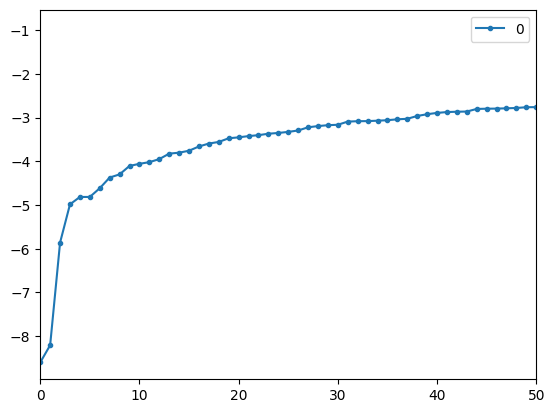

In [57]:
# This graph shows the ranked negative outlier factors and is often used to identify outliers.
# This type of visualisation is very useful in detecting outliers, as significant dips
# in the graph may indicate outliers.

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

In [58]:
# Set the threshold value for outliers (4th smallest value)

th = np.sort(df_scores)[3]

In [59]:
# Detected outliers

df[df_scores < th]

,carat,depth,table,price,x,y,z
41918,1.030,78.200,54.000,1262,5.720,5.590,4.420
48410,0.510,61.800,54.700,1970,5.120,5.150,31.800
49189,0.510,61.800,55.000,2075,5.150,31.800,5.120


In [60]:
# Detected outliers' indexes

df[df_scores < th].index

Index([41918, 48410, 49189], dtype='int64')

In [61]:
# Analyzed outliers and deleted. Because not many have outlier and detected outliers have really out values.

df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
carat,53940.000,0.798,0.474,0.200,0.240,0.300,0.700,1.040,1.510,2.180,5.010
depth,53940.000,61.749,1.433,43.000,57.900,59.300,61.800,62.500,63.300,65.600,79.000
table,53940.000,57.457,2.234,43.000,53.000,54.000,57.000,59.000,60.000,64.000,95.000
price,53940.000,3932.800,3989.440,326.000,429.000,544.000,2401.000,5324.250,9821.000,17378.220,18823.000
x,53940.000,5.731,1.122,0.000,4.020,4.290,5.700,6.540,7.310,8.360,10.740
y,53940.000,5.735,1.142,0.000,4.040,4.300,5.710,6.540,7.300,8.340,58.900
z,53940.000,3.539,0.706,0.000,2.480,2.650,3.530,4.040,4.520,5.150,31.800


In [62]:
# Outliers' indexes

df[df_scores < th].index

Index([41918, 48410, 49189], dtype='int64')

In [63]:
df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index)

,carat,depth,table,price,x,y,z
